In [4]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from tqdm import tqdm
from rdkit.Chem import rdFMCS
import os
    
def get_tanimoto_similarity(row):
    ligand = row['Docked']
    # Assuming that Template is somehow related to Ligand
    # For example, if templates correspond to ligands directly:
    template = row['Template']
    # Here we would retrieve the similarity based on the Ligand
    # Assuming we want to compare each Ligand with all Ligands and store the score
    # The following just returns the similarity of the Ligand with itself
    try:
        ts = similarity_matrix.loc[ligand, template]
    except:
        ts = None
    return ts
 

def get_mcs_size(row):
    temp = row['Template']
    dock = row['Docked']
    soft_mcs = Chem.MolFromSmarts(rdFMCS.FindMCS([mol_dict[temp],mol_dict[dock]],
                              atomCompare=rdFMCS.AtomCompare.CompareElements,
                              bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                              ringMatchesRingOnly=False,
                              timeout=1).smartsString)
 
    return soft_mcs.GetNumAtoms()

# Load csv files

In [2]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv')
astex['Template'] = astex.PDB + '_' + astex.Lig

ds = pd.read_csv('free_docking/docking_score_rmsd.csv')
hs = pd.read_csv('free_docking/hyde_score_rmsd.csv')
mcs_1 = pd.read_csv('free_docking/mcs_rmsd_dataset_1.0.csv')
mcs_2 = pd.read_csv('free_docking/mcs_rmsd_dataset_1.5.csv')
mcs_3 = pd.read_csv('free_docking/mcs_rmsd_dataset_2.0.csv')

ds = ds.rename(columns={'Ligand_ID': 'Docked'})
hs = hs.rename(columns={'Ligand_ID': 'Docked'})


In [13]:
ds

,UniProt_ID,Template,Docked,Pose_ID,rmsd
0,O14757,1NVQ_UCN,1NVQ_UCN,1,1.304
1,O14757,1NVQ_UCN,1NVQ_UCN,2,1.060
2,O14757,1NVQ_UCN,1NVQ_UCN,3,1.268
3,O14757,1NVQ_UCN,1NVR_STU,1,1.195
4,O14757,1NVQ_UCN,1NVR_STU,2,1.308
...,...,...,...,...,...
568779,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,2,0.626
568780,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,3,2.294
568781,Q9GPQ4,3EPX_IMQ,3EPX_IMQ,1,2.414
568782,Q9GPQ4,3EPX_IMQ,3EPX_IMQ,2,2.487


In [5]:
# Calculate simiarity matrix

temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

ligand_names = list(fp_dict.keys())

if os.path.exists('similarity_matrix.csv'):
    
    similarity_matrix = pd.read_csv('similarity_matrix.csv')
    similarity_matrix.index = similarity_matrix.columns
else:    
    similarity_matrix = pd.DataFrame(index=ligand_names, columns=ligand_names)
    for ligand1 in tqdm(ligand_names):
        for ligand2 in ligand_names:
            sim = DataStructs.TanimotoSimilarity(fp_dict[ligand1], fp_dict[ligand2])
            similarity_matrix.loc[ligand1, ligand2] = sim

    similarity_matrix.to_csv('similarity_matrix.csv', index=None)

similarity_matrix

[17:20:42] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[17:20:42] Explicit valence for atom # 35 O, 2, is greater than permitted


,3TKH_07S,4HYH_1AM,4HYI_1AO,4JIK_1KO,3OT3_22K,2HY0_306,2HXQ_373,2CGU_3A3,2CGW_3C3,2CGX_3D3,...,1W1Y_TYP,1JJT_BDS,1JJE_BYS,6AQS_IM5,1NW4_IMH,1Q1G_MTI,1HP0_AD3,3B9G_IMH,3EPX_IMQ,3EPW_JMQ
3TKH_07S,1.000000,0.163636,0.151515,0.135922,0.067961,0.130000,0.110000,0.109756,0.067416,0.090909,...,0.137931,0.137500,0.144578,0.103093,0.087912,0.082474,0.134831,0.087912,0.147727,0.105263
4HYH_1AM,0.163636,1.000000,0.463415,0.160377,0.094340,0.155340,0.125000,0.141176,0.097826,0.096774,...,0.141304,0.089888,0.086022,0.130000,0.060606,0.088235,0.091837,0.060606,0.114583,0.110000
4HYI_1AO,0.151515,0.463415,1.000000,0.197802,0.108696,0.129032,0.144444,0.077922,0.087500,0.113924,...,0.151899,0.106667,0.129870,0.151163,0.070588,0.065934,0.107143,0.070588,0.148148,0.114943
4JIK_1KO,0.135922,0.160377,0.197802,1.000000,0.166667,0.148936,0.115789,0.088608,0.071429,0.151899,...,0.132530,0.088608,0.084337,0.120879,0.093023,0.086957,0.103448,0.093023,0.116279,0.111111
3OT3_22K,0.067961,0.094340,0.108696,0.166667,1.000000,0.109890,0.100000,0.039474,0.106667,0.076923,...,0.087500,0.039474,0.037500,0.104651,0.048193,0.056818,0.098765,0.048193,0.085366,0.068966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1Q1G_MTI,0.082474,0.088235,0.065934,0.086957,0.056818,0.103448,0.093023,0.104478,0.068493,0.144928,...,0.108108,0.072464,0.068493,0.232877,0.281250,1.000000,0.135135,0.281250,0.135135,0.375000
1HP0_AD3,0.134831,0.091837,0.107143,0.103448,0.098765,0.069767,0.084337,0.093750,0.104478,0.136364,...,0.098592,0.111111,0.104478,0.178082,0.181818,0.135135,1.000000,0.181818,0.230769,0.183099
3B9G_IMH,0.087912,0.060606,0.070588,0.093023,0.048193,0.084337,0.086420,0.096774,0.058824,0.158730,...,0.101449,0.062500,0.058824,0.217391,1.000000,0.281250,0.181818,1.000000,0.181818,0.261538
3EPX_IMQ,0.147727,0.114583,0.148148,0.116279,0.085366,0.135802,0.153846,0.111111,0.072464,0.102941,...,0.114286,0.111111,0.121212,0.264706,0.181818,0.135135,0.230769,0.181818,1.000000,0.473684


In [6]:
clean_astex = astex[astex['Template'].isin(ligand_names)]

uniprots = astex.UniProt_ID.unique()

count_df = astex.groupby('UniProt_ID').size().reset_index(name='count')
count_df

,UniProt_ID,count
0,O14757,73
1,O43570,12
2,O76074,17
3,P00183,3
4,P00374,22
...,...,...
67,Q24451,30
68,Q54276,5
69,Q79MP6,2
70,Q8I3X4,3


In [7]:
for uni in uniprots:
    lig_list = clean_astex[clean_astex.UniProt_ID == uni].Template.to_list()
    sim_df = similarity_matrix.loc[lig_list, lig_list]
    
    count6 = (sim_df.where(np.triu(np.ones(sim_df.shape), k=1) == 1) >= 0.6).sum().sum()
    count7 = (sim_df.where(np.triu(np.ones(sim_df.shape), k=1) == 1) >= 0.7).sum().sum()
    count8 = (sim_df.where(np.triu(np.ones(sim_df.shape), k=1) == 1) >= 0.8).sum().sum()

    count_df.loc[count_df['UniProt_ID'] == uni, 'TS_6'] = int(count6*2)
    count_df.loc[count_df['UniProt_ID'] == uni, 'TS_7'] = int(count7*2)
    count_df.loc[count_df['UniProt_ID'] == uni, 'TS_8'] = int(count8*2)

In [8]:
count_df['TS_6'] = count_df['TS_6'].astype(int)
count_df['TS_7'] = count_df['TS_7'].astype(int)
count_df['TS_8'] = count_df['TS_8'].astype(int)
count_df

,UniProt_ID,count,TS_6,TS_7,TS_8
0,O14757,73,40,16,2
1,O43570,12,10,2,0
2,O76074,17,30,24,12
3,P00183,3,0,0,0
4,P00374,22,14,10,2
...,...,...,...,...,...
67,Q24451,30,28,16,6
68,Q54276,5,0,0,0
69,Q79MP6,2,2,2,2
70,Q8I3X4,3,0,0,0


In [10]:
tot = 0

for i, uni, t, ts6, ts7,ts8 in count_df.itertuples():
    tot += t*(t-1)

print(tot)
print(count_df.TS_6.sum())
print(count_df.TS_7.sum())
# print(count_df.TS_8.sum())

228354
2986
1326


In [11]:
# Select best FlexX and HYDE score
top1_ds = ds[ds.Pose_ID == 1]
top1_hs = hs.drop_duplicates(subset=['UniProt_ID', 'Template', 'Docked'], keep='first').reset_index(drop=True)

# Select best of the top 3 Flexx and HYDE score 
top3_ds = ds.loc[ds.groupby(by=['UniProt_ID', 'Template', 'Docked'])['rmsd'].idxmin()] 
top3_hs = hs.loc[hs.groupby(by=['UniProt_ID', 'Template', 'Docked'])['rmsd'].idxmin()]



In [12]:
top3_ds

,UniProt_ID,Template,Docked,Pose_ID,rmsd
1,O14757,1NVQ_UCN,1NVQ_UCN,2,1.060
3,O14757,1NVQ_UCN,1NVR_STU,1,1.195
7,O14757,1NVQ_UCN,2BR1_PFP,2,2.918
11,O14757,1NVQ_UCN,2BRB_PFQ,3,6.510
12,O14757,1NVQ_UCN,2BRG_DFY,1,2.392
...,...,...,...,...,...
568769,Q9GPQ4,3EPW_JMQ,3EPX_IMQ,1,2.365
568774,Q9GPQ4,3EPX_IMQ,1HP0_AD3,3,1.284
568775,Q9GPQ4,3EPX_IMQ,3B9G_IMH,1,0.400
568778,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,1,0.461


In [15]:
top1_hs['Tanimoto_Similarity'] = top1_hs.apply(get_tanimoto_similarity, axis=1)
mcs_1['Tanimoto_Similarity'] = mcs_1.apply(get_tanimoto_similarity, axis=1)
mcs_2['Tanimoto_Similarity'] = mcs_2.apply(get_tanimoto_similarity, axis=1)
mcs_3['Tanimoto_Similarity'] = mcs_3.apply(get_tanimoto_similarity, axis=1)


In [16]:
top1_hs = top1_hs.dropna().reset_index(drop=True)
mcs_1 = mcs_1.dropna().reset_index(drop=True)
mcs_2 = mcs_2.dropna().reset_index(drop=True)
mcs_3 = mcs_3.dropna().reset_index(drop=True)


In [17]:
hs_6 = top1_hs[top1_hs.Tanimoto_Similarity >= 0.6]
mcs_1_6 = mcs_1[mcs_1.Tanimoto_Similarity >= 0.6]
mcs_2_6 = mcs_2[mcs_2.Tanimoto_Similarity >= 0.6]
mcs_3_6 = mcs_3[mcs_3.Tanimoto_Similarity >= 0.6]

hs_7 = top1_hs[top1_hs.Tanimoto_Similarity >= 0.7]
mcs_1_7 = mcs_1[mcs_1.Tanimoto_Similarity >= 0.7]
mcs_2_7 = mcs_2[mcs_2.Tanimoto_Similarity >= 0.7]
mcs_3_7 = mcs_3[mcs_3.Tanimoto_Similarity >= 0.7]


In [18]:
top1_hs

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
0,O14757,1NVQ_UCN,1NVQ_UCN,6,1.265,1.000000
1,O14757,1NVQ_UCN,1NVR_STU,1,1.305,0.726027
2,O14757,1NVQ_UCN,2BR1_PFP,3,7.136,0.113402
3,O14757,1NVQ_UCN,2BRB_PFQ,2,7.370,0.107527
4,O14757,1NVQ_UCN,2BRG_DFY,1,2.232,0.105263
...,...,...,...,...,...,...
190116,Q9GPQ4,3EPW_JMQ,3EPX_IMQ,6,2.837,0.473684
190117,Q9GPQ4,3EPX_IMQ,1HP0_AD3,8,2.030,0.230769
190118,Q9GPQ4,3EPX_IMQ,3B9G_IMH,9,2.222,0.181818
190119,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,9,2.210,0.473684


In [16]:
top1_hs[top1_hs.rmsd <=2]


,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
0,O14757,1NVQ_UCN,1NVQ_UCN,6,1.265,1.000000
1,O14757,1NVQ_UCN,1NVR_STU,1,1.305,0.726027
6,O14757,1NVQ_UCN,2BRM_DFZ,2,1.719,0.108696
7,O14757,1NVQ_UCN,2BRO_DF2,7,1.561,0.104167
9,O14757,1NVQ_UCN,2C3L_IDZ,6,0.786,0.094118
...,...,...,...,...,...,...
190104,Q8I3X4,6AQS_IM5,6AQS_IM5,1,0.623,1.000000
190108,Q9GPQ4,1HP0_AD3,3EPX_IMQ,6,0.753,0.230769
190109,Q9GPQ4,3B9G_IMH,1HP0_AD3,1,1.981,0.181818
190112,Q9GPQ4,3B9G_IMH,3EPX_IMQ,9,1.608,0.181818


# Self-docking

In [19]:
s_top1_ds = top1_ds[top1_ds.Template == top1_ds.Docked]
s_top3_ds = top3_ds[top3_ds.Template == top3_ds.Docked]

s_top1_hs = top1_hs[top1_hs.Template == top1_hs.Docked]
s_top3_hs = top3_hs[top3_hs.Template == top3_hs.Docked]


s_mcs_1 = mcs_1[mcs_1.Template == mcs_1.Docked]
s_mcs_2 = mcs_2[mcs_2.Template == mcs_2.Docked]
s_mcs_3 = mcs_3[mcs_3.Template == mcs_3.Docked]


In [20]:
len(s_top1_ds[s_top1_ds.rmsd <= 2])

905

In [21]:
print('SELF-DOCKING SUCCESS RATES')
print(f'Docking score top 1: {round(len(s_top1_ds[s_top1_ds.rmsd <= 2])/len(ligand_names), 2)}')
print(f'Docking score top 3: {round(len(s_top3_ds[s_top3_ds.rmsd <= 2])/len(ligand_names), 2)}')

print(f'HYDE score top 1: {round(len(s_top1_hs[s_top1_hs.rmsd <= 2])/len(ligand_names), 2)}')
print(f'HYDE score top 3: {round(len(s_top3_hs[s_top3_hs.rmsd <= 2])/len(ligand_names), 2)}')

print(f'MCS 1.0 Å: {round(len(s_mcs_1[s_mcs_1.rmsd <= 2])/len(ligand_names), 2)}')
print(f'MCS 1.5 Å: {round(len(s_mcs_2[s_mcs_2.rmsd <= 2])/len(ligand_names), 2)}')
print(f'MCS 2.0 Å: {round(len(s_mcs_3[s_mcs_3.rmsd <= 2])/len(ligand_names), 2)}')


SELF-DOCKING SUCCESS RATES
Docking score top 1: 0.45
Docking score top 3: 0.55
HYDE score top 1: 0.55
HYDE score top 3: 0.62
MCS 1.0 Å: 0.45
MCS 1.5 Å: 0.59
MCS 2.0 Å: 0.67


In [22]:
sd_target_results = pd.DataFrame(columns=['FD Top 1 Docking Score', 'FD Top 1 HYDE', 'TBD Top 1 Docking Score', 'TBD Top 1 HYDE'])

for uni in clean_astex.UniProt_ID.unique():
    if uni == 'P04818': continue
    else:
        target_df = s_top1_hs[s_top1_hs.UniProt_ID == uni]
        if target_df.empty:
            sd_target_results.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 HYDE'] = \
                                -2
        else:
            sd_target_results.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 HYDE'] = \
                                round(len(target_df[target_df.rmsd <= 2])/len(target_df), 2)*100
        
        target_df = s_top1_ds[s_top1_ds.UniProt_ID == uni]
        if target_df.empty:
            sd_target_results.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 Docking Score'] = \
                                -2
        else:
            sd_target_results.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 Docking Score'] = \
                                round(len(target_df[target_df.rmsd <= 2])/len(target_df), 2)*100

In [23]:
sd_number_of_ligands = pd.DataFrame(columns=['FD Top 1 Docking Score', 'FD Top 1 HYDE', 'TBD Top 1 Docking Score', 'TBD Top 1 HYDE'])

for uni in clean_astex.UniProt_ID.unique():
    if uni == 'P04818': continue
    else:
        target_df = s_top1_hs[s_top1_hs.UniProt_ID == uni]
        
        sd_number_of_ligands.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 HYDE'] = \
                                len(target_df)
        sd_number_of_ligands.loc[f'{uni} ({len(clean_astex[clean_astex.UniProt_ID == uni])})', 'FD Top 1 Docking Score'] = \
                                len(target_df)

In [24]:
sd_number_of_ligands

,FD Top 1 Docking Score,FD Top 1 HYDE,TBD Top 1 Docking Score,TBD Top 1 HYDE
O14757 (73),73,73,NaN,NaN
O43570 (12),12,12,NaN,NaN
O76074 (17),17,17,NaN,NaN
P00183 (3),3,3,NaN,NaN
P00374 (22),21,21,NaN,NaN
...,...,...,...,...
Q24451 (30),30,30,NaN,NaN
Q54276 (5),3,3,NaN,NaN
Q79MP6 (2),2,2,NaN,NaN
Q8I3X4 (3),3,3,NaN,NaN


In [98]:
sd_target_results.to_csv('self_docking_success_rates.csv', index=True)
sd_number_of_ligands.to_csv('self_docking_number_of_ligands.csv', index=True)

# No self docking

In [25]:
n_top1_ds = top1_ds[top1_ds.Template != top1_ds.Docked]
n_top3_ds = top3_ds[top3_ds.Template != top3_ds.Docked]

n_top1_hs = top1_hs[top1_hs.Template != top1_hs.Docked]
n_top3_hs = top3_hs[top3_hs.Template != top3_hs.Docked]

n_hs_6 = hs_6[hs_6.Template != hs_6.Docked]
n_hs_7 = hs_7[hs_7.Template != hs_7.Docked]

n_mcs_1 = mcs_1[mcs_1.Template != mcs_1.Docked]
n_mcs_2 = mcs_2[mcs_2.Template != mcs_2.Docked]
n_mcs_3 = mcs_3[mcs_3.Template != mcs_3.Docked]

n_mcs_1_6 = n_mcs_1[n_mcs_1.Tanimoto_Similarity >= 0.6]
n_mcs_2_6 = n_mcs_2[n_mcs_2.Tanimoto_Similarity >= 0.6]
n_mcs_3_6 = n_mcs_3[n_mcs_3.Tanimoto_Similarity >= 0.6]

n_mcs_1_7 = n_mcs_1[n_mcs_1.Tanimoto_Similarity >= 0.7]
n_mcs_2_7 = n_mcs_2[n_mcs_2.Tanimoto_Similarity >= 0.7]
n_mcs_3_7 = n_mcs_3[n_mcs_3.Tanimoto_Similarity >= 0.7]

n_mcs_1_8 = n_mcs_1[n_mcs_1.Tanimoto_Similarity >= 0.8]
n_mcs_2_8 = n_mcs_2[n_mcs_2.Tanimoto_Similarity >= 0.8]
n_mcs_3_8 = n_mcs_3[n_mcs_3.Tanimoto_Similarity >= 0.8]

In [26]:
n_mcs_2_7[n_mcs_2_7.UniProt_ID == 'O43570']

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
1450,O43570,4QJO_V1F,4QJW_WWO,7,1.487,0.790698
1466,O43570,4QJW_WWO,4QJO_V1F,10,2.164,0.790698


In [27]:
print('DOCKING SUCCESS RATES (self docking excluded)')
print(f'Docking score top 1: {round(len(n_top1_ds[n_top1_ds.rmsd <= 2])/len(n_top1_ds), 2)}')
print(f'Docking score top 3: {round(len(n_top3_ds[n_top3_ds.rmsd <= 2])/len(n_top3_ds), 2)}')

print(f'HYDE score top 1: {round(len(n_top1_hs[n_top1_hs.rmsd <= 2])/len(n_top1_hs), 2)}')
print(f'HYDE score top 3: {round(len(n_top3_hs[n_top3_hs.rmsd <= 2])/len(n_top3_hs), 2)}')

print(f'MCS 1.0 Å: {round(len(n_mcs_1[n_mcs_1.rmsd <= 2])/len(n_mcs_1), 2)}')
print(f'MCS 1.5 Å: {round(len(n_mcs_2[n_mcs_2.rmsd <= 2])/len(n_mcs_2), 2)}')
print(f'MCS 2.0 Å: {round(len(n_mcs_3[n_mcs_3.rmsd <= 2])/len(n_mcs_3), 2)}')


print(f'HYDE score top 1 TS > 6: {round(len(n_hs_6[n_hs_6.rmsd <= 2])/len(n_hs_6), 2)}')
print(f'HYDE score top 1 TS > 7: {round(len(n_hs_7[n_hs_7.rmsd <= 2])/len(n_hs_7), 2)}')

print(f'MCS 1.0 Å + TS > 6: {round(len(n_mcs_1_6[n_mcs_1_6.rmsd <= 2])/len(n_mcs_1_6), 2)}')
print(f'MCS 1.5 Å + TS > 6: {round(len(n_mcs_2_6[n_mcs_2_6.rmsd <= 2])/len(n_mcs_2_6), 2)}')
print(f'MCS 2.0 Å + TS > 6: {round(len(n_mcs_3_6[n_mcs_3_6.rmsd <= 2])/len(n_mcs_2_6), 2)}')

print(f'MCS 1.0 Å + TS>=7: {round(len(n_mcs_1_7[n_mcs_1_7.rmsd <= 2])/len(n_mcs_1_7), 2)}')
print(f'MCS 1.5 Å + TS>=7: {round(len(n_mcs_2_7[n_mcs_2_7.rmsd <= 2])/len(n_mcs_2_7), 2)}')
print(f'MCS 2.0 Å + TS>=7: {round(len(n_mcs_3_7[n_mcs_3_7.rmsd <= 2])/len(n_mcs_3_7), 2)}')

print(f'MCS 1.0 Å + TS>=8: {round(len(n_mcs_1_8[n_mcs_1_8.rmsd <= 2])/len(n_mcs_1_8), 2)}')
print(f'MCS 1.5 Å + TS>=8: {round(len(n_mcs_2_8[n_mcs_2_8.rmsd <= 2])/len(n_mcs_2_8), 2)}')
print(f'MCS 2.0 Å + TS>=8: {round(len(n_mcs_3_8[n_mcs_3_8.rmsd <= 2])/len(n_mcs_3_8), 2)}')

DOCKING SUCCESS RATES (self docking excluded)
Docking score top 1: 0.21
Docking score top 3: 0.29
HYDE score top 1: 0.26
HYDE score top 3: 0.33
MCS 1.0 Å: 0.42
MCS 1.5 Å: 0.39
MCS 2.0 Å: 0.35
HYDE score top 1 TS > 6: 0.5
HYDE score top 1 TS > 7: 0.53
MCS 1.0 Å + TS > 6: 0.81
MCS 1.5 Å + TS > 6: 0.79
MCS 2.0 Å + TS > 6: 0.85
MCS 1.0 Å + TS>=7: 0.86
MCS 1.5 Å + TS>=7: 0.83
MCS 2.0 Å + TS>=7: 0.78
MCS 1.0 Å + TS>=8: 0.85
MCS 1.5 Å + TS>=8: 0.8
MCS 2.0 Å + TS>=8: 0.78


In [23]:
sr_df = pd.DataFrame(columns=['Poses', '% of total', 'Success Rate', 
                              'Poses', '% of total', 'Success Rate'], 
                     index=['Hyde score', 'MCS RMSD 1.0', 'MCS RMSD 1.5', 'MCS RMSD 2.0'])
sr_df

,Poses,% of total,Success Rate,Poses,% of total,Success Rate
Hyde score,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.0,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 1.5,NaN,NaN,NaN,NaN,NaN,NaN
MCS RMSD 2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
228354
2980
1316
388


388

In [25]:
sr_df.iloc[0, 0] = len(n_hs_6)
sr_df.iloc[0, 1] = round(len(n_hs_6)/2980, 2)
sr_df.iloc[0, 2] = round(len(n_hs_6[n_hs_6.rmsd <= 2])/len(n_hs_6), 2)

sr_df.iloc[0, 3] = len(n_hs_7)
sr_df.iloc[0, 4] = round(len(n_hs_7)/1316, 2)
sr_df.iloc[0, 5] = round(len(n_hs_7[n_hs_7.rmsd <= 2])/len(n_hs_7), 2)

sr_df.iloc[1, 0] = len(n_mcs_1_6)
sr_df.iloc[1, 1] = round(len(n_mcs_1_6)/2980, 2)
sr_df.iloc[1, 2] = round(len(n_mcs_1_6[n_mcs_1_6.rmsd <= 2])/len(n_mcs_1_6), 2)

sr_df.iloc[1, 3] = len(n_mcs_1_7)
sr_df.iloc[1, 4] = round(len(n_mcs_1_7)/1316, 2)
sr_df.iloc[1, 5] = round(len(n_mcs_1_7[n_mcs_1_7.rmsd <= 2])/len(n_mcs_1_7), 2)


sr_df.iloc[2, 0] = len(n_mcs_2_6)
sr_df.iloc[2, 1] = round(len(n_mcs_2_6)/2980, 2)
sr_df.iloc[2, 2] = round(len(n_mcs_2_6[n_mcs_2_6.rmsd <= 2])/len(n_mcs_2_6), 2)

sr_df.iloc[2, 3] = len(n_mcs_2_7)
sr_df.iloc[2, 4] = round(len(n_mcs_2_7)/1316, 2)
sr_df.iloc[2, 5] = round(len(n_mcs_2_7[n_mcs_2_7.rmsd <= 2])/len(n_mcs_2_7), 2)

sr_df.iloc[3, 0] = len(n_mcs_3_6)
sr_df.iloc[3, 1] = round(len(n_mcs_3_6)/2980, 2)
sr_df.iloc[3, 2] = round(len(n_mcs_3_6[n_mcs_3_6.rmsd <= 2])/len(n_mcs_3_6), 2)

sr_df.iloc[3, 3] = len(n_mcs_3_7)
sr_df.iloc[3, 4] = round(len(n_mcs_3_7)/1316, 2)
sr_df.iloc[3, 5] = round(len(n_mcs_3_7[n_mcs_3_7.rmsd <= 2])/len(n_mcs_3_7), 2)


In [26]:
round(len(n_mcs_3_7[n_mcs_3_7.rmsd <= 2.5])/len(n_mcs_3_7), 2)

0.86

In [27]:
sr_df

,Poses,% of total,Success Rate,Poses,% of total,Success Rate
Hyde score,2850,0.96,0.5,1281,0.97,0.53
MCS RMSD 1.0,1354,0.45,0.81,603,0.46,0.86
MCS RMSD 1.5,1749,0.59,0.79,793,0.6,0.83
MCS RMSD 2.0,2028,0.68,0.74,916,0.7,0.78


In [27]:
print(sr_df.to_latex())

\begin{tabular}{lllllll}
\toprule
 & Poses & % of total & Success Rate & Poses & % of total & Success Rate \\
\midrule
Hyde score & 2850 & 0.960000 & 0.500000 & 1281 & 0.970000 & 0.530000 \\
MCS RMSD 1.0 & 1354 & 0.450000 & 0.810000 & 603 & 0.460000 & 0.860000 \\
MCS RMSD 1.5 & 1749 & 0.590000 & 0.790000 & 793 & 0.600000 & 0.830000 \\
MCS RMSD 2.0 & 2028 & 0.680000 & 0.740000 & 916 & 0.700000 & 0.780000 \\
\bottomrule
\end{tabular}



In [36]:
n_mcs_3_7

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
925,O14757,3PA3_C70,3PA4_C72,3,0.427,0.730159
953,O14757,3PA4_C72,3PA3_C70,7,0.456,0.730159
956,O14757,3PA4_C72,6FC8_D4Q,1,0.736,0.765625
987,O14757,3PA5_C73,2YDK_YDK,8,1.095,0.814815
1005,O14757,6FC8_D4Q,3PA4_C72,8,0.743,0.765625
...,...,...,...,...,...,...
99639,Q24451,3EJQ_HN3,3EJP_HN2,10,0.320,0.767442
99641,Q24451,3EJQ_HN3,3EJU_HN7,1,0.707,0.760870
99659,Q24451,3EJR_HN4,3EJU_HN7,4,0.704,1.000000
99974,Q79MP6,1JJT_BDS,1JJE_BYS,2,0.465,0.882353


In [37]:
ref_lig_rmsd = pd.read_csv('../data/reference_ligands_rmsd.csv')
ref_lig_rmsd = ref_lig_rmsd.drop(columns='Unnamed: 0')
ref_lig_rmsd.rename(columns={'rmsd': 'ref_rmsd'}, inplace=True)
ref_lig_rmsd.rename(columns={'UniProtID': 'UniProt_ID'}, inplace=True)
ref_lig_rmsd

,UniProt_ID,Template,Docked,ref_rmsd
0,O14757,3TKH_07S,3TKH_07S,0.000
1,O14757,3TKH_07S,4HYH_1AM,10.711
2,O14757,3TKH_07S,4HYI_1AO,10.763
3,O14757,3TKH_07S,4JIK_1KO,7.224
4,O14757,3TKH_07S,3OT3_22K,1.263
...,...,...,...,...
230359,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,0.273
230360,Q9GPQ4,3EPW_JMQ,1HP0_AD3,NaN
230361,Q9GPQ4,3EPW_JMQ,3B9G_IMH,0.769
230362,Q9GPQ4,3EPW_JMQ,3EPX_IMQ,0.273


In [38]:
df_merged = n_mcs_3_7.merge(ref_lig_rmsd, on=['UniProt_ID', 'Template', 'Docked'], how='left')
df_merged

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity,ref_rmsd
0,O14757,3PA3_C70,3PA4_C72,3,0.427,0.730159,0.163
1,O14757,3PA4_C72,3PA3_C70,7,0.456,0.730159,0.163
2,O14757,3PA4_C72,6FC8_D4Q,1,0.736,0.765625,0.455
3,O14757,3PA5_C73,2YDK_YDK,8,1.095,0.814815,0.388
4,O14757,6FC8_D4Q,3PA4_C72,8,0.743,0.765625,0.455
...,...,...,...,...,...,...,...
911,Q24451,3EJQ_HN3,3EJP_HN2,10,0.320,0.767442,0.095
912,Q24451,3EJQ_HN3,3EJU_HN7,1,0.707,0.760870,0.649
913,Q24451,3EJR_HN4,3EJU_HN7,4,0.704,1.000000,0.553
914,Q79MP6,1JJT_BDS,1JJE_BYS,2,0.465,0.882353,1.081


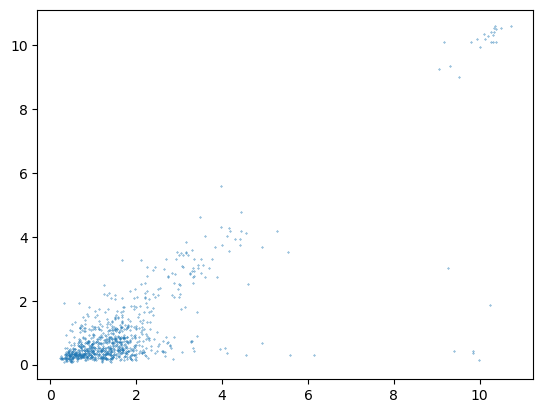

In [39]:
plt.scatter(df_merged.rmsd, df_merged.ref_rmsd, s=0.1)
plt.savefig('paper_images/rmsd_ref_rmsd_corr.png', dpi=300)

In [53]:
df_merged['rmsd'].corr(df_merged['ref_rmsd'], method='pearson')

np.float64(0.8282849199607758)

In [69]:
test_8 = df_merged[df_merged['ref_rmsd'] >= 8]
test_8.rmsd.corr(test_8['ref_rmsd'], method='pearson')

np.float64(0.7986594193189114)

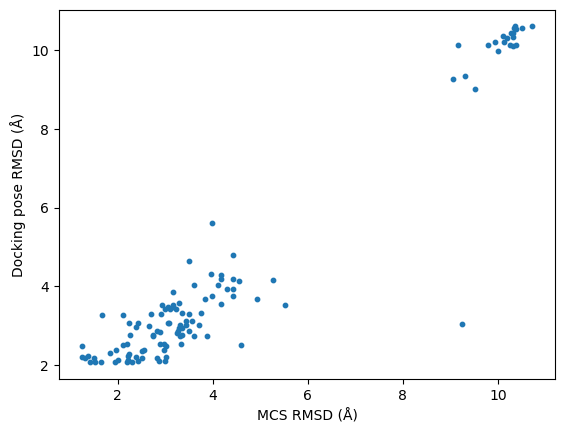

In [68]:
plt.scatter(test_8.rmsd, test_8.ref_rmsd, s=10)
plt.xlabel('MCS RMSD (Å)')
plt.ylabel('Docking pose RMSD (Å)')
plt.savefig('paper_images/rmsd_ref_rmsd_corr_refrmsd_g_2.png', dpi=300)

In [49]:
df_merged[(df_merged.rmsd > 8)]

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity,ref_rmsd
373,P04585,5DGU_5B7,4Q1Y_017,5,9.522,0.719512,9.013
568,P29476,4CTP_2IK,4CTU_S42,9,9.394,0.739130,0.413
569,P29476,4CTP_2IK,4CTQ_S5D,2,9.941,1.000000,10.188
591,P29476,3NNZ_59W,3NNY_59R,1,10.107,1.000000,10.360
592,P29476,3NNZ_59W,3NLM_JRR,2,10.317,0.803279,10.326
663,P29476,3UFO_HW4,3UFW_HW0,5,10.314,0.745763,10.097
669,P29476,3JWU_J11,3JX3_JI5,6,10.361,1.000000,10.594
670,P29476,3JWU_J11,3NLM_JRR,10,10.382,0.738462,10.121
673,P29476,3JWV_J14,3NLM_JRR,1,9.160,0.738462,10.113
680,P29476,3JX3_JI5,3JWU_J11,6,10.727,1.000000,10.594


# Paper images

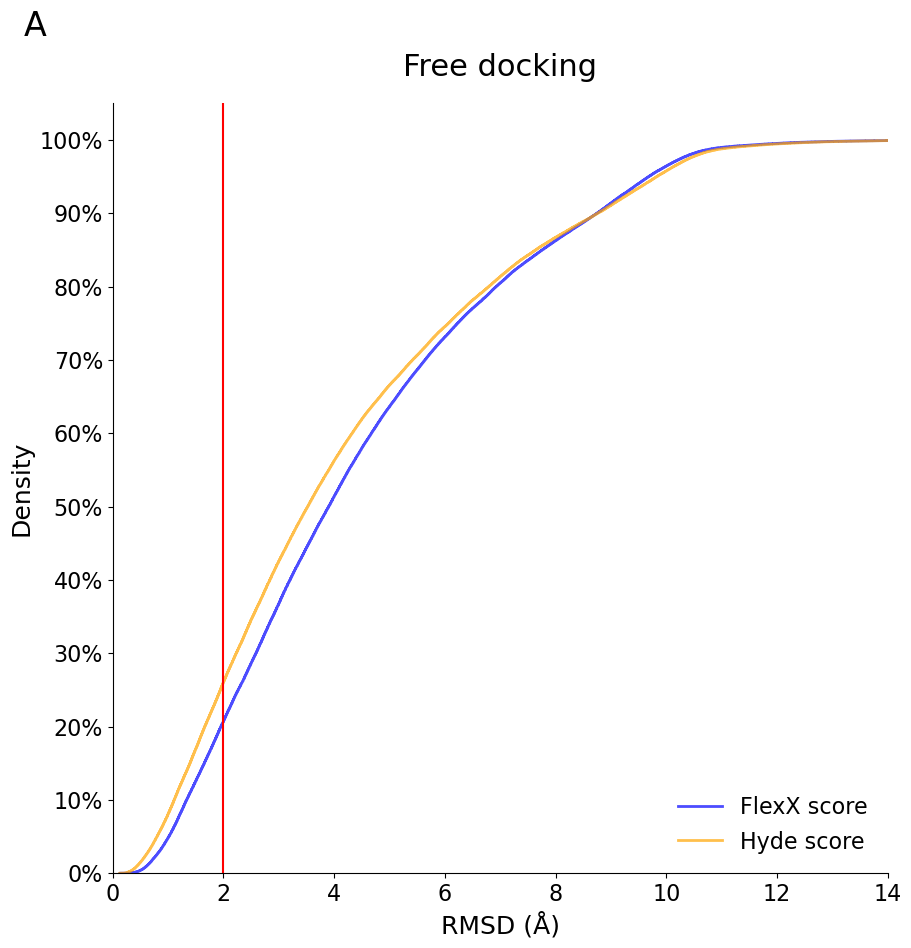

In [95]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot cumulative distribution
plt.ecdf(n_top1_ds.rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
plt.ecdf(n_top1_hs.rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')
 
# Add labels and title
plt.xlabel('RMSD (Å)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Free docking', fontsize=22, pad=20)

# Add legend
plt.legend(fontsize=16, frameon=False)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.05)
plt.xlim(0,14)
# Add gridlines
plt.axvline(x=2, color='red', linestyle='-')
plt.text(-0.1, 1.1, 'A', fontsize=24, ha='center', va='center', transform=plt.gca().transAxes)

plt.gca().set_yticks(np.linspace(0, 1, 11))
plt.gca().set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')


# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'Docking Score', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/free_docking_ds_hs.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot

plt.show()

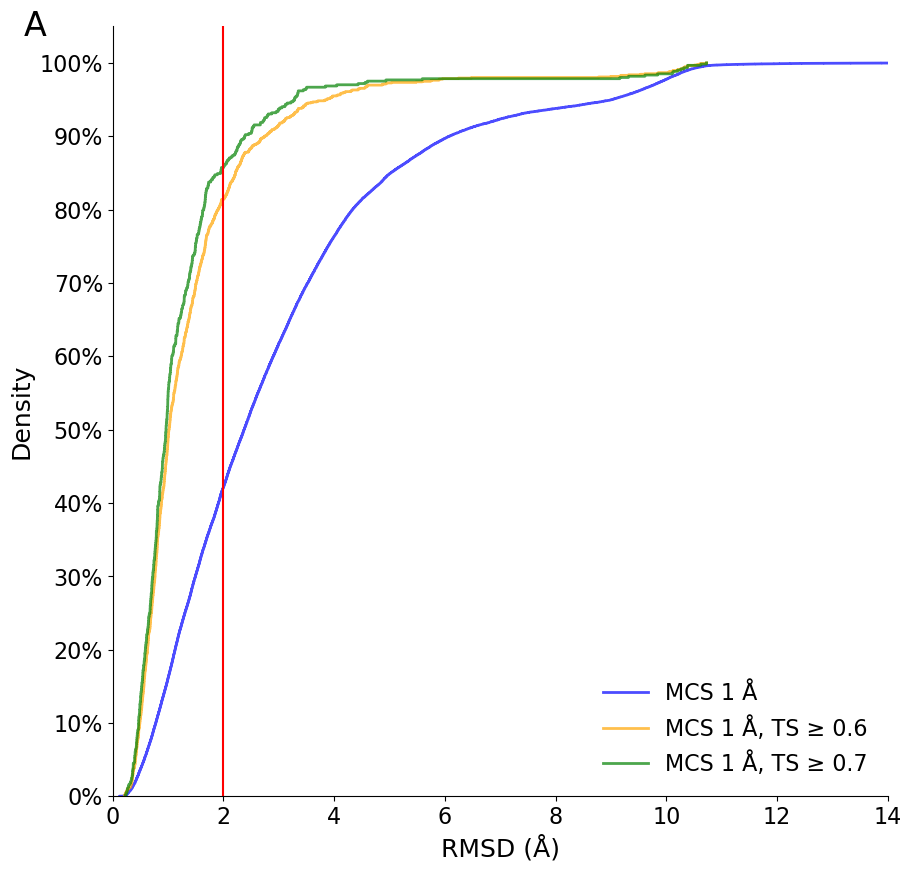

In [96]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot cumulative distribution
plt.ecdf(n_mcs_1.rmsd, alpha=0.7, label='MCS 1 Å', linewidth=2, linestyle='-', color='blue')
plt.ecdf(n_mcs_1_6.rmsd, alpha=0.7, label='MCS 1 Å, TS ≥ 0.6', linewidth=2, linestyle='-', color='orange')
plt.ecdf(n_mcs_1_7.rmsd, alpha=0.7, label='MCS 1 Å, TS ≥ 0.7', linewidth=2, linestyle='-', color='green')
 
# Add labels and title
plt.xlabel('RMSD (Å)', fontsize=18)
plt.ylabel('Density', fontsize=18)
# plt.title('Free docking', fontsize=22, pad=20)

# Add legend
plt.legend(fontsize=16, frameon=False)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.05)
plt.xlim(0,14)
# Add gridlines
plt.axvline(x=2, color='red', linestyle='-')
plt.text(-0.1, 1, 'A', fontsize=24, ha='center', va='center', transform=plt.gca().transAxes)

plt.gca().set_yticks(np.linspace(0, 1, 11))
plt.gca().set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')


# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'Docking Score', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/free_docking_mcs1_ts.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot

plt.show()

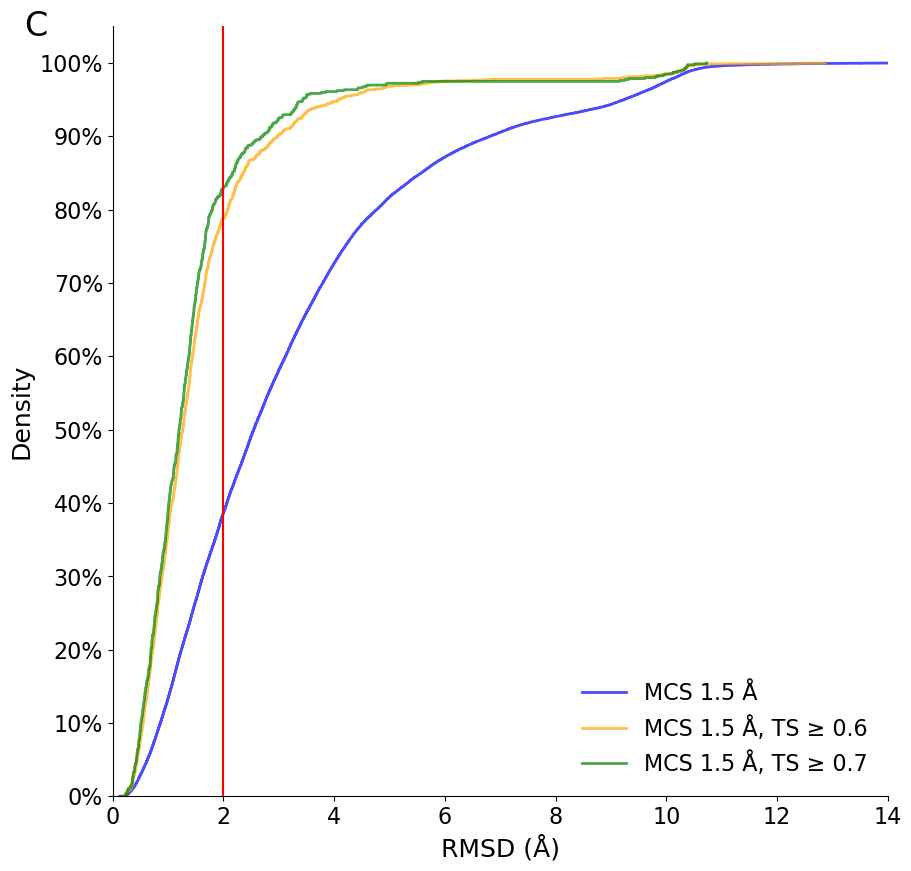

In [97]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot cumulative distribution
plt.ecdf(n_mcs_2.rmsd, alpha=0.7, label='MCS 1.5 Å', linewidth=2, linestyle='-', color='blue')
plt.ecdf(n_mcs_2_6.rmsd, alpha=0.7, label='MCS 1.5 Å, TS ≥ 0.6', linewidth=2, linestyle='-', color='orange')
plt.ecdf(n_mcs_2_7.rmsd, alpha=0.7, label='MCS 1.5 Å, TS ≥ 0.7', linewidth=2, linestyle='-', color='green')
 
# Add labels and title
plt.xlabel('RMSD (Å)', fontsize=18)
plt.ylabel('Density', fontsize=18)
# plt.title('Free docking', fontsize=22, pad=20)

# Add legend
plt.legend(fontsize=16, frameon=False)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.05)
plt.xlim(0,14)
# Add gridlines
plt.axvline(x=2, color='red', linestyle='-')
plt.text(-0.1, 1, 'C', fontsize=24, ha='center', va='center', transform=plt.gca().transAxes)

plt.gca().set_yticks(np.linspace(0, 1, 11))
plt.gca().set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')


# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'Docking Score', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/free_docking_mcs1.5_ts.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot

plt.show()

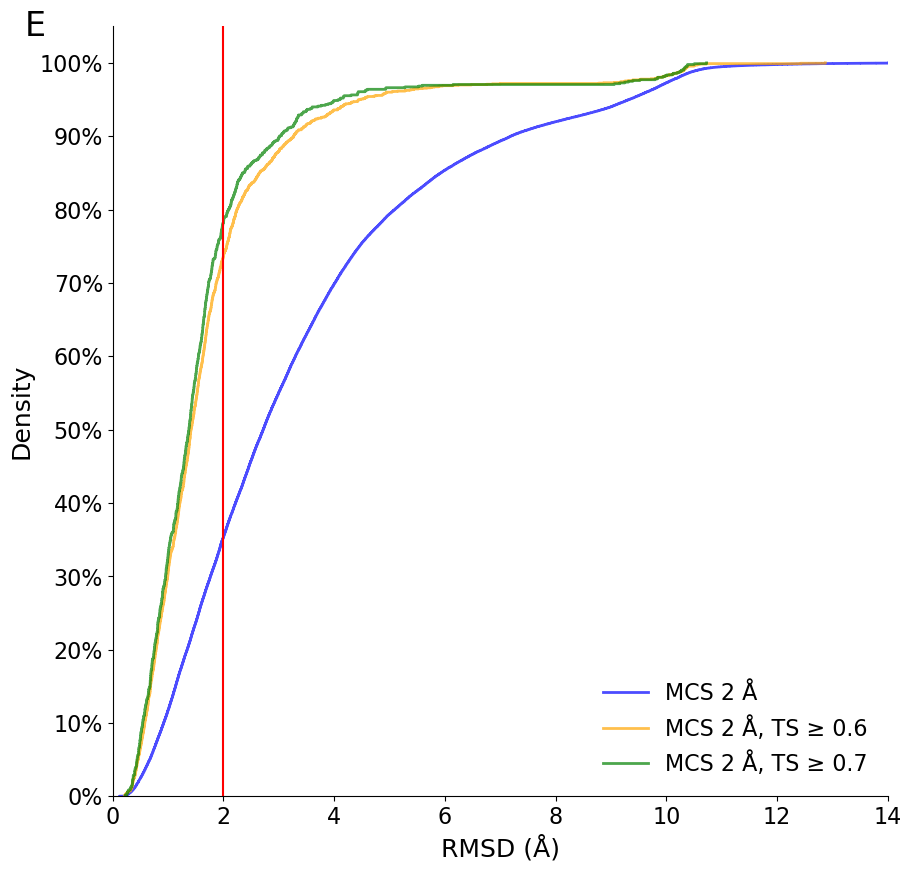

In [98]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot cumulative distribution
plt.ecdf(n_mcs_3.rmsd, alpha=0.7, label='MCS 2 Å', linewidth=2, linestyle='-', color='blue')
plt.ecdf(n_mcs_3_6.rmsd, alpha=0.7, label='MCS 2 Å, TS ≥ 0.6', linewidth=2, linestyle='-', color='orange')
plt.ecdf(n_mcs_3_7.rmsd, alpha=0.7, label='MCS 2 Å, TS ≥ 0.7', linewidth=2, linestyle='-', color='green')
 
# Add labels and title
plt.xlabel('RMSD (Å)', fontsize=18)
plt.ylabel('Density', fontsize=18)
# plt.title('Free docking', fontsize=22, pad=20)

# Add legend
plt.legend(fontsize=16, frameon=False)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.05)
plt.xlim(0,14)
# Add gridlines
plt.axvline(x=2, color='red', linestyle='-')
plt.text(-0.1, 1, 'E', fontsize=24, ha='center', va='center', transform=plt.gca().transAxes)

plt.gca().set_yticks(np.linspace(0, 1, 11))
plt.gca().set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)])


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')


# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'Docking Score', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/free_docking_mcs2_ts.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot

plt.show()

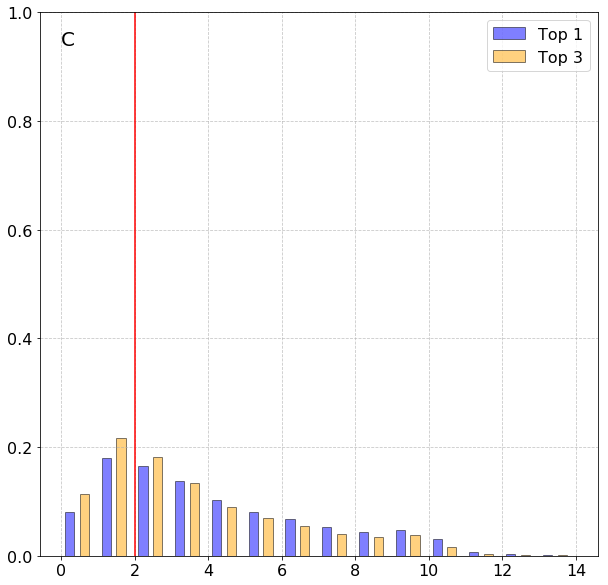

In [36]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot histograms
plt.hist([n_top1_hs.rmsd, n_top3_hs.rmsd], bins=bins,
         alpha=0.5, color=['blue', 'orange'], edgecolor='black',
         label=['Top 1', 'Top 3'],
         density=True, width=0.25)
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.0)
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='-')
plt.text(0.05, 0.95, 'C', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.1, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'HYDE Score', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/FD_hs.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot
plt.show()

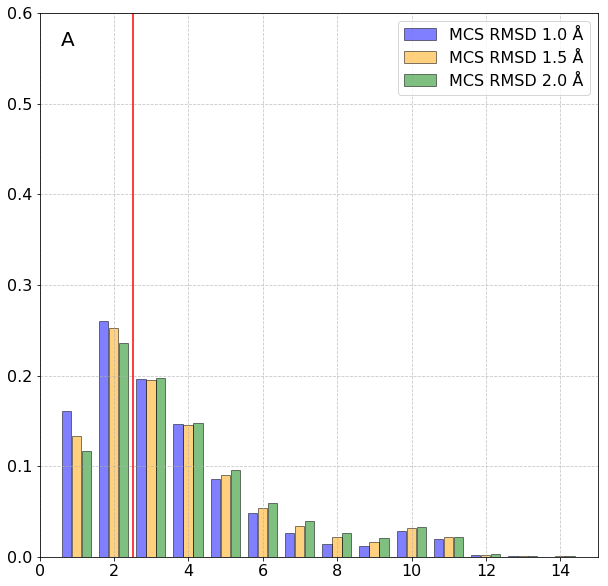

In [94]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot histograms
plt.hist([n_mcs_1.rmsd, n_mcs_2.rmsd, n_mcs_3.rmsd], bins=bins,
         alpha=0.5, color=['blue', 'orange', 'green'], edgecolor='black',
         label=['MCS RMSD 1.0 Å', 'MCS RMSD 1.5 Å', 'MCS RMSD 2.0 Å'],
         density=True, width=0.25, align='right')
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,0.6)
plt.xlim(0,15)
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2.5, color='red', linestyle='-')
plt.text(0.05, 0.95, 'A', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'MCS RMSD', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
# plt.savefig('paper_images/FD_mcs.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot
plt.show()

<Figure size 720x720 with 0 Axes>

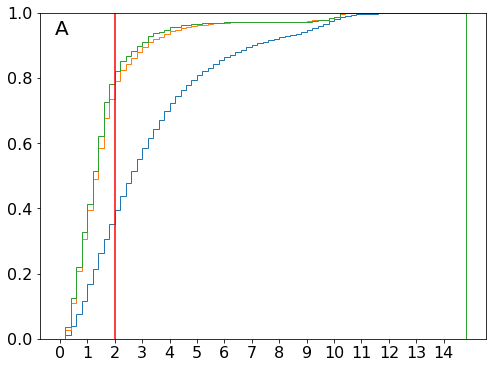

In [122]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 0.2)
 
# Plot histograms
fig = plt.figure(figsize=(8,6))
axs = fig.subplots(1, 1, sharex=True, sharey=True)

# Cumulative distributions.
# axs.ecdf(n_mcs_1.rmsd, label="CDF")
n, bins, patches = axs.hist(n_mcs_3.rmsd, bins, density=True, histtype="step",
                               cumulative=True, label="Cumulative histogram")
n, bins, patches = axs.hist(n_mcs_3_6.rmsd, bins, density=True, histtype="step",
                               cumulative=True, label="Cumulative histogram")
n, bins, patches = axs.hist(n_mcs_3_7.rmsd, bins, density=True, histtype="step",
                               cumulative=True, label="Cumulative histogram")
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
# plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.0)
# Add gridlines
# plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='-')
plt.text(0.05, 0.95, 'A', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.05, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'MCS RMSD', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
# plt.savefig('paper_images/FD_mcs.png', dpi=300, bbox_inches='tight', transparent=True)
plt.xticks(np.arange(0, 15, 1))  # Adjust step size as needed

# Show the plot
plt.show()

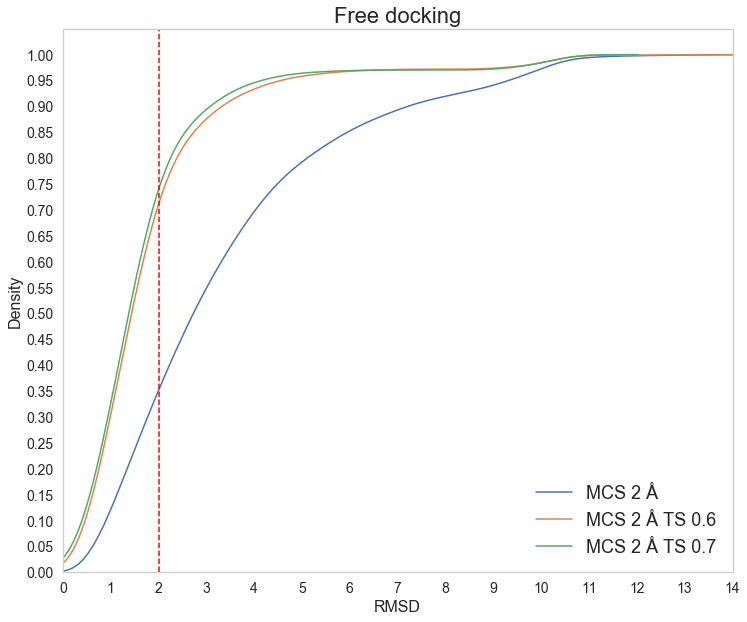

In [395]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12,10))

# sns.kdeplot(data = n_top1_hs.rmsd, cumulative = True, label = "HYDE score")
sns.kdeplot(data = n_mcs_3.rmsd, cumulative = True, label = "MCS 2 Å")
sns.kdeplot(data = n_mcs_3_6.rmsd, cumulative = True, label = "MCS 2 Å TS 0.6")
sns.kdeplot(data = n_mcs_3_7.rmsd, cumulative = True,  label = "MCS 2 Å TS 0.7")
plt.axvline(x=2, color='red', linestyle='--')
plt.grid(False)
plt.xticks(np.arange(0, 15, 1))
plt.xticks(np.arange(0, 15, 1), fontsize=14)
plt.yticks(np.arange(0, 1.05, 0.05), fontsize=14)
plt.xlabel('RMSD',fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Free docking', fontsize=22)
plt.xlim(0,14)  # Manually set the x-axis to start at 0
plt.legend(frameon=False, fontsize=18)
plt.savefig('paper_images/new_density_fd.png', dpi=600)
plt.show()

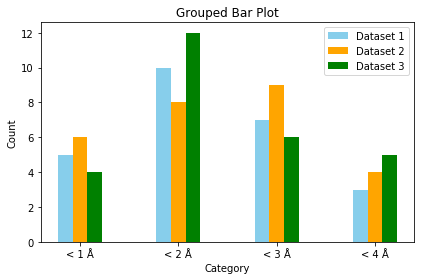

In [77]:

# Example data
categories = ['< 1 Å', '< 2 Å', '< 3 Å', '< 4 Å']
data1 = [5, 10, 7, 3]
data2 = [6, 8, 9, 4]
data3 = [4, 12, 6, 5]

# Bar width
bar_width = 0.15

# X positions for each group
x = np.arange(len(categories))

# Create the grouped bar plot
plt.bar(x - bar_width, data1, width=bar_width, label='Dataset 1', color='skyblue')
plt.bar(x, data2, width=bar_width, label='Dataset 2', color='orange')
plt.bar(x + bar_width, data3, width=bar_width, label='Dataset 3', color='green')

# Add labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Grouped Bar Plot')
plt.xticks(x, categories)  # Set the x-axis tick labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

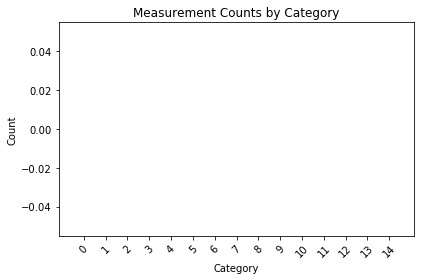

In [88]:
# Example DataFrame
data = {'Measurements': [0.5, 1.2, 2.8, 3.7, 4.6, 5.5, 6.9, 7.1, 8.4, 9.3, 10.7, 11.8, 12.9, 13.6, 14.2]}
df = pd.DataFrame(data)

# Define the bins and labels, including a range for values below 1
bins = [-float('inf'), 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, float('inf')]  # include values below 1
labels = range(0, 15)  # Create labels from 0 to 14

# Group measurements into categories
df['Category'] = pd.cut(n_mcs_1_6['rmsd'], bins=bins, labels=labels, right=False)
category_counts = df['Category'].value_counts().sort_index()  # Count the occurrences per category

# Plotting
plt.bar(category_counts.index.astype(str), category_counts.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Measurement Counts by Category')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [86]:
n_mcs_1

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
0,O14757,3TKH_07S,4RVL_3XL,7,6.859,0.120879
1,O14757,3TKH_07S,5OP4_A0T,4,1.555,0.217822
3,O14757,4HYH_1AM,2CGU_3A3,3,1.375,0.141176
4,O14757,4HYH_1AM,4RVL_3XL,9,7.033,0.113402
5,O14757,4HYH_1AM,2WMX_ZY6,9,6.696,0.126214
...,...,...,...,...,...,...
61975,Q9GPQ4,1HP0_AD3,3EPX_IMQ,6,0.753,0.230769
61976,Q9GPQ4,3EPX_IMQ,1HP0_AD3,3,0.813,0.230769
61977,Q9GPQ4,3EPX_IMQ,3B9G_IMH,1,0.502,0.181818
61978,Q9GPQ4,3EPX_IMQ,3EPW_JMQ,1,0.375,0.473684


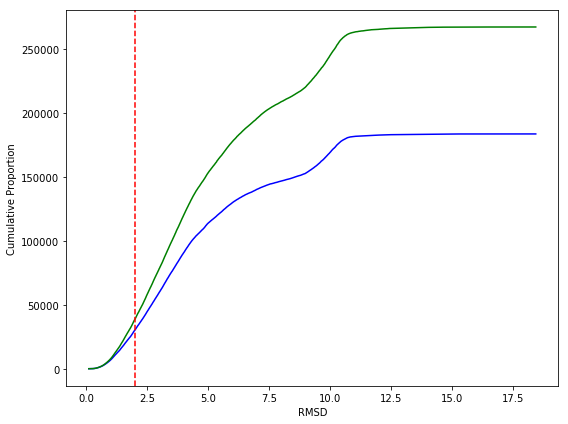

In [54]:
threshold = 2

data_1 = n_mcs_1['rmsd'].dropna()  # Drop NaN values if any
sorted_1 = np.sort(data_1)
cumulative_1 = np.cumsum(sorted_1) 
percent_below_threshold_1 = np.sum(sorted_1 <= threshold) / len(sorted_1) * 100

data_2 = n_mcs_2['rmsd'].dropna()  # Drop NaN values if any
sorted_2 = np.sort(data_2)
cumulative_2 = np.cumsum(sorted_2) 
percent_below_threshold_2 = np.sum(sorted_2 <= threshold) / len(sorted_2) * 100


plt.figure(figsize=(8, 6))
plt.plot(sorted_1, cumulative_1, linestyle='-', color='blue')
plt.plot(sorted_2, cumulative_2, linestyle='-', color='green')

# Mark the threshold
plt.axvline(x=threshold, color='red', linestyle='--')

# Labels and title
plt.xlabel("RMSD")
plt.ylabel("Cumulative Proportion")
# plt.title("CDF of RMSD Values")
# plt.legend()
# plt.grid()
plt.tight_layout()
plt.show()

In [53]:
cumulative_1

array([6.41747499e-07, 1.36507307e-06, 2.11559133e-06, ...,
       9.99810293e-01, 9.99899828e-01, 1.00000000e+00])

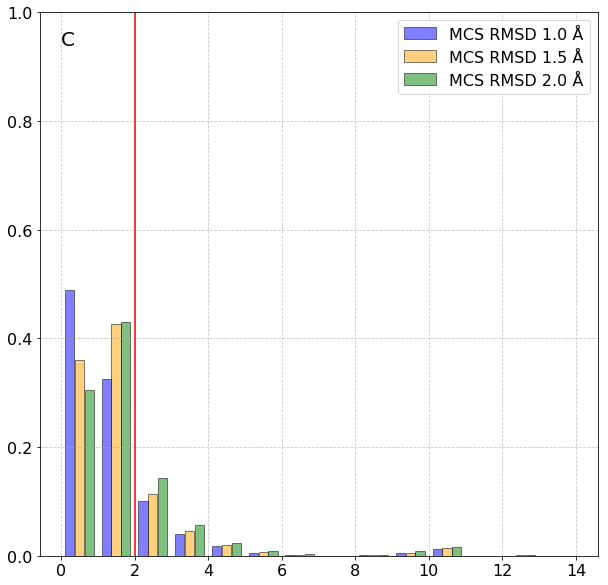

In [39]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot histograms
plt.hist([n_mcs_1_6.rmsd, n_mcs_2_6.rmsd, n_mcs_3_6.rmsd], bins=bins,
         alpha=0.5, color=['blue', 'orange', 'green'], edgecolor='black',
         label=['MCS RMSD 1.0 Å', 'MCS RMSD 1.5 Å', 'MCS RMSD 2.0 Å'],
         density=True, width=0.25)
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.0)
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='-')
plt.text(0.05, 0.95, 'C', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.1, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'TS ≥ 0.6', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/FD_mcs_ts6.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot
plt.show()

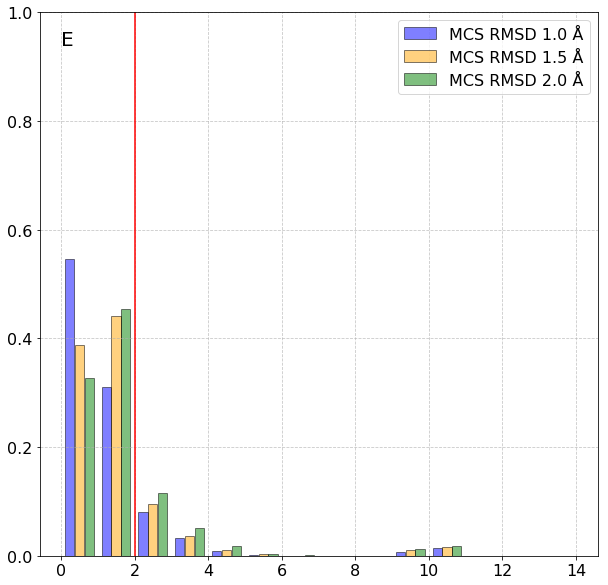

In [40]:
plt.figure(figsize=(10, 10))  # Size in inches (width, height)
bins = np.arange(0, 15, 1)
 
# Plot histograms
plt.hist([n_mcs_1_7.rmsd, n_mcs_2_7.rmsd, n_mcs_3_7.rmsd], bins=bins,
         alpha=0.5, color=['blue', 'orange', 'green'], edgecolor='black',
         label=['MCS RMSD 1.0 Å', 'MCS RMSD 1.5 Å', 'MCS RMSD 2.0 Å'],
         density=True, width=0.25)
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.0)
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='-')
plt.text(0.05, 0.95, 'E', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.1, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'TS ≥ 0.7', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
plt.savefig('paper_images/FD_mcs_ts7.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot
plt.show()

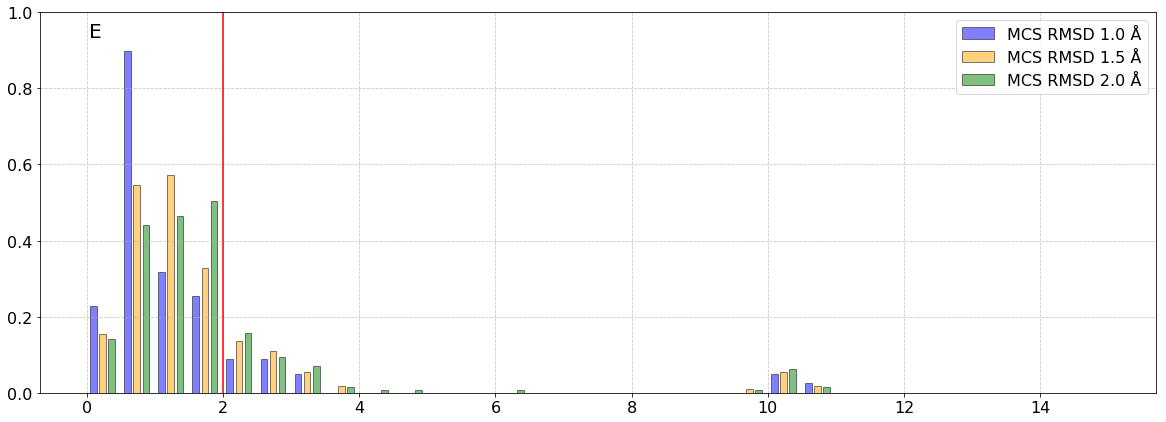

In [41]:
plt.figure(figsize=(20, 7))  # Size in inches (width, height)
# bins = np.arange(0, 15.5, 0.5)
 
# Plot histograms
plt.hist([n_mcs_1_8.rmsd, n_mcs_2_8.rmsd, n_mcs_3_8.rmsd], bins=bins,
         alpha=0.5, color=['blue', 'orange', 'green'], edgecolor='black',
         label=['MCS RMSD 1.0 Å', 'MCS RMSD 1.5 Å', 'MCS RMSD 2.0 Å'],
         density=True, width=0.1)
 
# Add labels and title
# plt.xlabel('RMSD (Å)', fontsize=18)
# plt.ylabel('Density', fontsize=18)
#plt.title('Template-based docking hyde score', fontsize=22)
 
# Add legend
plt.legend(fontsize=16)
 
# Adjust tick parameters for readability
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1.0)
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=2, color='red', linestyle='-')
plt.text(0.05, 0.95, 'E', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
# plt.text(7, 1.1, 'Free Docking', fontsize=22, ha='center', va='center')
# plt.text(-3, 0.5, 'TS ≥ 0.8', fontsize=22, rotation=90, ha='center', va='center')
# Save the figure with high resolution
# plt.savefig('paper_images/FD_mcs_ts7.png', dpi=300, bbox_inches='tight', transparent=True)
 
# Show the plot
plt.show()

In [96]:
dfs_mcs = [[n_mcs_1, n_mcs_2, n_mcs_3], [n_mcs_1_6, n_mcs_2_6, n_mcs_3_6], [n_mcs_1_7, n_mcs_2_7, n_mcs_3_7]]
titles_mcs = ['Free Docking MCS RMSD', 'Free Docking TS ≥ 0.6', 'Free Docking TS ≥ 0.7']
graph_id = ['A', 'C', 'E']

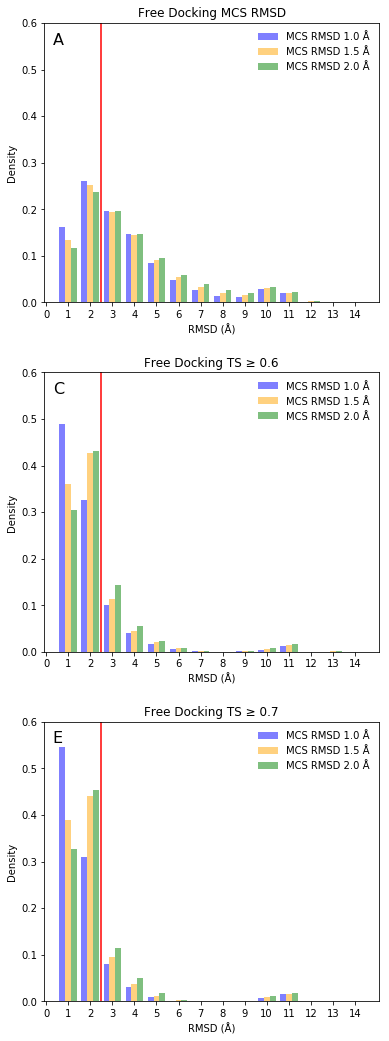

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(6, 18), sharex=False)  # Adjust figure size to make each plot square
# Plot data on each subplot
for i, (df, ax) in enumerate(zip(dfs_mcs, axes)):
    ax.hist([sub_df['rmsd'] for sub_df in df], bins=bins, alpha=0.5,
            color=['blue', 'orange', 'green'], 
            label=['MCS RMSD 1.0 Å', 'MCS RMSD 1.5 Å', 'MCS RMSD 2.0 Å'],
            density=True, align='right')
    
#     ax.grid(True, linestyle='--', alpha=0.7)

    ax.set_xlabel('RMSD (Å)')
    ax.set_ylabel('Density')
    ax.set_ylim(0,0.6)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.set_xticks(np.arange(0, 15, 1))  # Adjust step size as needed
    ax.axvline(x=2.5, color='red', linestyle='-')
    
    ax.set_title(titles_mcs[i])
    ax.text(0.3, 0.58, graph_id[i], fontsize=16, ha='left', va='top')

    ax.legend(frameon=False)
    plt.subplots_adjust(hspace=0.25)
# plt.tight_layout()
plt.savefig('paper_images/FD_mcs.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [44]:
dfs_ds_hs = [[n_top1_ds, n_top3_ds], [n_top1_hs, n_top3_hs]]
titles_ds_hs = ['Free Docking Docking Score', 'Free Docking HYDE Score']

In [56]:
bins

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ])

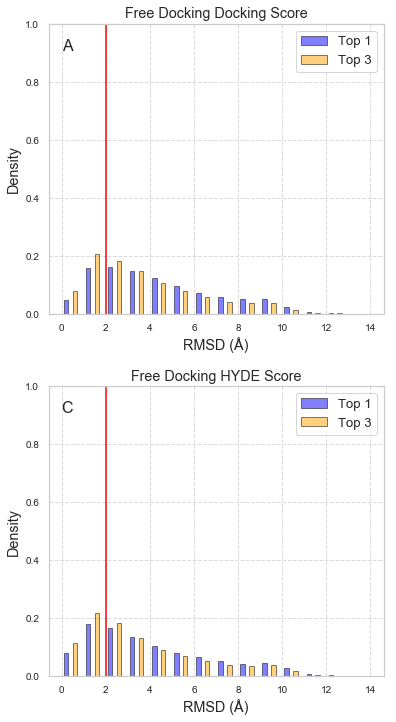

In [184]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12), sharex=False)  # Adjust figure size to make each plot square
# Plot data on each subplot
for i, (df, ax) in enumerate(zip(dfs_ds_hs, axes)):
    ax.hist([sub_df['rmsd'] for sub_df in df], bins=bins, alpha=0.5,
            color=['blue', 'orange'], edgecolor='black',
            label=['Top 1', 'Top 3'],
            density=True, width=0.2)
    
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.set_xlabel('RMSD (Å)')
    ax.set_ylabel('Density')
    ax.set_ylim(0,1.0)
    ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.axvline(x=2, color='red', linestyle='-')
    
    ax.set_title(titles_ds_hs[i])
    ax.text(0, 0.95, graph_id[i], fontsize=16, ha='left', va='top')

    ax.legend()
    plt.subplots_adjust(hspace=0.25)  # Increase hspace to add more vertical spacing
# plt.tight_layout()
plt.savefig('paper_images/FD_ds_hs.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Success rates by target

In [28]:
target_sr = pd.DataFrame(columns=['FD Top 1 Hyde',
                                  'FD MCS 1.0',
                                  'FD MCS 1.0 TS 0.6',
                                  'FD MCS 1.0 TS 0.7',
                                  'FD MCS 1.5',
                                  'FD MCS 1.5 TS 0.6',
                                  'FD MCS 1.5 TS 0.7',
                                  'FD MCS 2.0',
                                  'FD MCS 2.0 TS 0.6',
                                  'FD MCS 2.0 TS 0.7', 
                                  'TBD Top 1 Hyde',
                                  'TBD MCS 1.0',
                                  'TBD MCS 1.0 TS 0.6',
                                  'TBD MCS 1.0 TS 0.7',
                                  'TBD MCS 1.5',
                                  'TBD MCS 1.5 TS 0.6',
                                  'TBD MCS 1.5 TS 0.7',
                                  'TBD MCS 2.0',
                                  'TBD MCS 2.0 TS 0.6', 
                                  'TBD MCS 2.0 TS 0.7',
                                 ],
                         dtype=float
                        )


In [29]:
pair_left = pd.DataFrame(columns=['FD Top 1 Hyde',
                                  'FD MCS 1.0',
                                  'FD MCS 1.0 TS 0.6',
                                  'FD MCS 1.0 TS 0.7',
                                  'FD MCS 1.5',
                                  'FD MCS 1.5 TS 0.6',
                                  'FD MCS 1.5 TS 0.7',
                                  'FD MCS 2.0',
                                  'FD MCS 2.0 TS 0.6',
                                  'FD MCS 2.0 TS 0.7', 
                                  'TBD Top 1 Hyde',
                                  'TBD MCS 1.0',
                                  'TBD MCS 1.0 TS 0.6',
                                  'TBD MCS 1.0 TS 0.7',
                                  'TBD MCS 1.5',
                                  'TBD MCS 1.5 TS 0.6',
                                  'TBD MCS 1.5 TS 0.7',
                                  'TBD MCS 2.0',
                                  'TBD MCS 2.0 TS 0.6', 
                                  'TBD MCS 2.0 TS 0.7',
                                 ],
                         dtype=int
                        )

In [30]:
lig_left = pd.DataFrame(columns=['FD Top 1 Hyde',
                                  'FD MCS 1.0',
                                  'FD MCS 1.0 TS 0.6',
                                  'FD MCS 1.0 TS 0.7',
                                  'FD MCS 1.5',
                                  'FD MCS 1.5 TS 0.6',
                                  'FD MCS 1.5 TS 0.7',
                                  'FD MCS 2.0',
                                  'FD MCS 2.0 TS 0.6',
                                  'FD MCS 2.0 TS 0.7', 
                                  'TBD Top 1 Hyde',
                                  'TBD MCS 1.0',
                                  'TBD MCS 1.0 TS 0.6',
                                  'TBD MCS 1.0 TS 0.7',
                                  'TBD MCS 1.5',
                                  'TBD MCS 1.5 TS 0.6',
                                  'TBD MCS 1.5 TS 0.7',
                                  'TBD MCS 2.0',
                                  'TBD MCS 2.0 TS 0.6', 
                                  'TBD MCS 2.0 TS 0.7',
                                 ],
                         dtype=int
                        )

In [31]:
col_df_dict = {'FD Top 1 Hyde': n_top1_hs,
               'FD MCS 1.0': n_mcs_1,
               'FD MCS 1.5': n_mcs_2,
               'FD MCS 2.0': n_mcs_3,
               'FD MCS 1.0 TS 0.6': n_mcs_1_6,
               'FD MCS 1.5 TS 0.6': n_mcs_2_6,
               'FD MCS 2.0 TS 0.6': n_mcs_3_6,
               'FD MCS 1.0 TS 0.7': n_mcs_1_7,
               'FD MCS 1.5 TS 0.7': n_mcs_2_7,
               'FD MCS 2.0 TS 0.7': n_mcs_3_7,
               }

In [32]:
similarity_df = pd.DataFrame(columns=['Ligands', 'TS_6', 'TS_7'], index=count_df.UniProt_ID.to_list())
for uni in count_df.UniProt_ID:

    target_df = clean_astex[clean_astex.UniProt_ID == uni]
    similarity_df.loc[uni, 'Ligands'] = len(target_df)
    target_lig_list = target_df.Template.unique()
    
    target_simmat = similarity_matrix.loc[target_lig_list, target_lig_list]

    # Initialize an empty set to store molecules with TS >= 0.6
    ts6 = set()
    ts7 = set()

    for mol1 in target_simmat.index:
        # Exclude the diagonal by dropping the mol1 column for this row
        similarities = target_simmat.loc[mol1].drop(mol1)
        # Check if any value meets the threshold
        if (similarities >= 0.6).any():
            ts6.add(mol1)
        if (similarities >= 0.7).any():
            ts7.add(mol1)
            
    similarity_df.loc[uni, 'TS_6'] = len(ts6)
    similarity_df.loc[uni, 'TS_7'] = len(ts7)
    
similarity_df

,Ligands,TS_6,TS_7
O14757,73,29,14
O43570,12,9,2
O76074,17,8,8
P00183,3,0,0
P00374,22,13,9
...,...,...,...
Q24451,30,9,8
Q54276,5,0,0
Q79MP6,2,2,2
Q8I3X4,3,0,0


In [36]:
target_df = clean_astex[clean_astex.UniProt_ID == 'P02766']
similarity_df.loc[uni, 'Ligands'] = len(target_df)
target_lig_list = target_df.Template.unique()

target_simmat = similarity_matrix.loc[target_lig_list, target_lig_list]

# Initialize an empty set to store molecules with TS >= 0.6
ts6 = set()
ts7 = set()

for mol1 in target_simmat.index:
    for mol2 in target_simmat.index:

    # Exclude the diagonal by dropping the mol1 column for this row
        similarities = target_simmat.loc[mol1].drop(mol1)
        # Check if any value meets the threshold
        if (similarities >= 0.6).any():
            ts6.add(mol1)
        if (similarities >= 0.7).any():
            ts7.add(mol1)

In [37]:
ts7

{'3FC8_IFA',
 '3FCB_IFB',
 '3IPB_JZD',
 '3IPE_JZE',
 '4DER_AGI',
 '4DES_57D',
 '4DEW_LU2',
 '5EN3_7LU',
 '5IHH_6B5'}

In [44]:
n_mcs_3_6[n_mcs_3_6.UniProt_ID == 'P02766']

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
58489,P02766,3IPE_JZE,1U21_P2C,4,7.002,0.681818


In [46]:
similarity_matrix.loc['1U21_P2C', '3IPE_JZE']

0.6818181818181818

In [50]:
clean_astex[clean_astex.Template == '3IPE_JZE'].Smiles_String.iloc[0]

'c1ccc(c(c1)C(=O)O)Nc2cc(c(c(c2)Cl)OCCCCCCCOc3c(cc(cc3Cl)Nc4ccccc4C(=O)O)Cl)Cl'

In [33]:
for uni in count_df.UniProt_ID:

    target_df = clean_astex[clean_astex.UniProt_ID == uni]
    similarity_df.loc[uni, 'Ligands'] = len(target_df)
    target_lig_list = target_df.Template.unique()
    
    target_simmat = similarity_matrix.loc[target_lig_list, target_lig_list]

    # Initialize an empty set to store molecules with TS >= 0.6
    ts6 = set()
    ts7 = set()

    for mol1 in target_simmat.index:
        for mol2 in target_simmat.index:

        # Exclude the diagonal by dropping the mol1 column for this row
            similarities = target_simmat.loc[mol1].drop(mol1)
            # Check if any value meets the threshold
            if (similarities >= 0.6).any():
                ts6.add(mol1)
            if (similarities >= 0.7).any():
                ts7.add(mol1)
            


In [34]:
for i, t, t6, t7 in similarity_df[['Ligands', 'TS_6', 'TS_7']].itertuples():
    print(i, t, t6, t7)

O14757 73 29 14
O43570 12 9 2
O76074 17 8 8
P00183 3 0 0
P00374 22 13 9
P00520 5 4 0
P00734 116 62 42
P00742 83 51 28
P00749 44 17 14
P00811 26 7 7
P00918 322 156 99
P00929 10 5 0
P02766 38 10 9
P03176 4 0 0
P03369 34 24 19
P03372 46 22 12
P03472 12 7 4
P03474 4 3 2
P04035 18 8 6
P04058 15 7 6
P04150 8 0 0
P04585 23 15 10
P04818 1 0 0
P06401 9 0 0
P06875 8 2 0
P07342 3 2 2
P07900 143 70 43
P08473 5 0 0
P08709 33 12 9
P10275 9 2 0
P10721 2 0 0
P10828 2 0 0
P11086 19 2 0
P11712 2 0 0
P13922 2 0 0
P14780 3 0 0
P15090 23 18 4
P15121 41 17 14
P15917 11 8 6
P16083 24 6 4
P19971 2 0 0
P20231 5 0 0
P22906 13 8 7
P24941 128 51 37
P26281 18 12 6
P27487 43 18 6
P27707 11 8 6
P28720 38 23 20
P29476 200 182 158
P35557 2 0 0
P35968 20 0 0
P42260 3 0 0
P47811 10 4 4
P49354 5 0 0
P49841 22 2 0
P50097 3 0 0
P50579 16 4 0
P53779 29 16 11
P55859 10 2 2
P56658 10 9 8
P9WIL5 23 14 7
P9WKE1 10 3 3
Q00535 4 0 0
Q07343 21 2 0
Q07785 2 0 0
Q07912 3 0 0
Q08499 38 18 16
Q24451 30 9 8
Q54276 5 0 0
Q79MP6 2 2 2
Q8

In [35]:
for i, uni in enumerate(uniprots):
    for col in target_sr.columns:
        if 'TBD' in col: continue
            
        elif '0.6' in col:
            if count_df[count_df.UniProt_ID == uni].TS_6.iloc[0] == 0:
                target_sr.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    target_sr.loc[uni, str(col)] = -2
                else:
                    target_sr.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/len(target_df), 2)*100
                    
        elif '0.7' in col:
            if count_df[count_df.UniProt_ID == uni].TS_7.iloc[0] == 0:
                target_sr.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    target_sr.loc[uni, str(col)] = -2
                else:
                    target_sr.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/len(target_df), 2)*100
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                target_sr.loc[uni, str(col)] = -2
            else:
                target_sr.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/len(target_df), 2)*100
            
target_sr

,FD Top 1 Hyde,FD MCS 1.0,FD MCS 1.0 TS 0.6,FD MCS 1.0 TS 0.7,FD MCS 1.5,FD MCS 1.5 TS 0.6,FD MCS 1.5 TS 0.7,FD MCS 2.0,FD MCS 2.0 TS 0.6,FD MCS 2.0 TS 0.7,TBD Top 1 Hyde,TBD MCS 1.0,TBD MCS 1.0 TS 0.6,TBD MCS 1.0 TS 0.7,TBD MCS 1.5,TBD MCS 1.5 TS 0.6,TBD MCS 1.5 TS 0.7,TBD MCS 2.0,TBD MCS 2.0 TS 0.6,TBD MCS 2.0 TS 0.7
O14757,44.0,46.0,86.0,100.0,47.0,89.0,100.0,48.0,89.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O43570,39.0,42.0,100.0,-2.0,45.0,86.0,50.0,41.0,88.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O76074,30.0,55.0,62.0,73.0,47.0,57.0,58.0,43.0,54.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00374,24.0,27.0,100.0,100.0,29.0,100.0,100.0,31.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,28.0,52.0,100.0,100.0,45.0,100.0,100.0,45.0,92.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q54276,17.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,50.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q79MP6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q8I3X4,83.0,100.0,-1.0,-1.0,100.0,-1.0,-1.0,83.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
target_sr[(target_sr['FD Top 1 Hyde'] <= 10) &
              (target_sr['FD Top 1 Hyde'] != -1) & 
              (target_sr['FD Top 1 Hyde'] != -2)]

,FD Top 1 Hyde,FD MCS 1.0,FD MCS 1.0 TS 0.6,FD MCS 1.0 TS 0.7,FD MCS 1.5,FD MCS 1.5 TS 0.6,FD MCS 1.5 TS 0.7,FD MCS 2.0,FD MCS 2.0 TS 0.6,FD MCS 2.0 TS 0.7,TBD Top 1 Hyde,TBD MCS 1.0,TBD MCS 1.0 TS 0.6,TBD MCS 1.0 TS 0.7,TBD MCS 1.5,TBD MCS 1.5 TS 0.6,TBD MCS 1.5 TS 0.7,TBD MCS 2.0,TBD MCS 2.0 TS 0.6,TBD MCS 2.0 TS 0.7
P00811,10.0,39.0,100.0,100.0,31.0,100.0,100.0,26.0,75.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P02766,4.0,12.0,-2.0,-2.0,8.0,-2.0,-2.0,5.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P03369,4.0,56.0,-2.0,-2.0,57.0,75.0,100.0,43.0,57.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P04058,5.0,3.0,0.0,-2.0,4.0,0.0,-2.0,8.0,25.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P07342,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P11712,0.0,-2.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P13922,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P14780,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P35557,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P49354,10.0,50.0,-1.0,-1.0,33.0,-1.0,-1.0,33.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
similarity_matrix.loc[clean_astex[clean_astex.UniProt_ID == 'P00183'].Template.to_list(), 
                      clean_astex[clean_astex.UniProt_ID == 'P00183'].Template.to_list()]

,2H7R_1MZ,2GQX_5CL,1MPW_TMH
2H7R_1MZ,1.0,0.04,0.057143
2GQX_5CL,0.04,1.0,0.064516
1MPW_TMH,0.057143,0.064516,1.0


In [101]:
for i, uni in enumerate(uniprots):
    for col in target_sr.columns:
        if 'TBD' in col: continue
            
        elif '0.6' in col:
            if count_df[count_df.UniProt_ID == uni].TS_6.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_6'].iloc[0]
                    total_pairs = lig_pairs*2
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/total_pairs, 2)*100
                    
        elif '0.7' in col:
            if count_df[count_df.UniProt_ID == uni].TS_7.iloc[0] == 0:
                pair_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    pair_left.loc[uni, str(col)] = -2
                else:
                    lig_pairs = count_df[count_df.UniProt_ID == uni]['TS_7'].iloc[0]
                    total_pairs = lig_pairs*2
                    pair_left.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/total_pairs, 2)*100
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                pair_left.loc[uni, str(col)] = -2
            else:
                lig_pairs = count_df[count_df.UniProt_ID == uni]['count'].iloc[0]
                total_pairs = lig_pairs*(lig_pairs-1)
                pair_left.loc[uni, str(col)] = round(len(target_df[target_df.rmsd <= 2])/total_pairs, 2)*100            
pair_left

,FD Top 1 Hyde,FD MCS 1.0,FD MCS 1.0 TS 0.6,FD MCS 1.0 TS 0.7,FD MCS 1.5,FD MCS 1.5 TS 0.6,FD MCS 1.5 TS 0.7,FD MCS 2.0,FD MCS 2.0 TS 0.6,FD MCS 2.0 TS 0.7,TBD Top 1 Hyde,TBD MCS 1.0,TBD MCS 1.0 TS 0.6,TBD MCS 1.0 TS 0.7,TBD MCS 1.5,TBD MCS 1.5 TS 0.6,TBD MCS 1.5 TS 0.7,TBD MCS 2.0,TBD MCS 2.0 TS 0.6,TBD MCS 2.0 TS 0.7
O14757,36.0,7.0,31.0,28.0,12.0,40.0,47.0,16.0,40.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O43570,39.0,21.0,20.0,-2.0,33.0,30.0,25.0,34.0,35.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O76074,21.0,8.0,13.0,17.0,13.0,22.0,23.0,14.0,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00374,23.0,13.0,21.0,15.0,16.0,25.0,15.0,19.0,29.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,28.0,20.0,16.0,12.0,24.0,20.0,16.0,29.0,21.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q54276,10.0,10.0,-1.0,-1.0,10.0,-1.0,-1.0,10.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q79MP6,100.0,100.0,50.0,50.0,100.0,50.0,50.0,100.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q8I3X4,83.0,83.0,-1.0,-1.0,83.0,-1.0,-1.0,83.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
for i, uni in enumerate(uniprots):
    for col in lig_left.columns:
        if 'TBD' in col: continue
            
        elif '0.6' in col:
            if similarity_df.loc[uni].TS_6 == 0:
                lig_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    lig_left.loc[uni, str(col)] = -2
                else:
                    ligs = similarity_df.loc[uni].TS_6
                    lig_left.loc[uni, str(col)] = int(len(target_df[target_df.rmsd <= 2].Docked.unique()))
                    
        elif '0.7' in col:
            if similarity_df.loc[uni].TS_7 == 0:
                lig_left.loc[uni, str(col)] = -1
            
            else:
                target_df = col_df_dict[col]
                target_df = target_df[target_df.UniProt_ID == uni]
                if target_df.empty:
                    lig_left.loc[uni, str(col)] = -2
                else:
                    ligs = similarity_df.loc[uni].TS_7
                    lig_left.loc[uni, str(col)] = int(len(target_df[target_df.rmsd <= 2].Docked.unique()))
        else:
            target_df = col_df_dict[col]
            target_df = target_df[target_df.UniProt_ID == uni]
            if target_df.empty:
                lig_left.loc[uni, str(col)] = -2
            else:
                ligs = similarity_df.loc[uni].Ligands
                lig_left.loc[uni, str(col)] = int(len(target_df[target_df.rmsd <= 2].Docked.unique()))
lig_left

,FD Top 1 Hyde,FD MCS 1.0,FD MCS 1.0 TS 0.6,FD MCS 1.0 TS 0.7,FD MCS 1.5,FD MCS 1.5 TS 0.6,FD MCS 1.5 TS 0.7,FD MCS 2.0,FD MCS 2.0 TS 0.6,FD MCS 2.0 TS 0.7,TBD Top 1 Hyde,TBD MCS 1.0,TBD MCS 1.0 TS 0.6,TBD MCS 1.0 TS 0.7,TBD MCS 1.5,TBD MCS 1.5 TS 0.6,TBD MCS 1.5 TS 0.7,TBD MCS 2.0,TBD MCS 2.0 TS 0.6,TBD MCS 2.0 TS 0.7
O14757,69.0,56.0,21.0,8.0,65.0,26.0,13.0,67.0,26.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O43570,9.0,7.0,4.0,-2.0,9.0,6.0,1.0,9.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
O76074,11.0,9.0,4.0,4.0,9.0,4.0,4.0,9.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00183,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P00374,19.0,17.0,6.0,3.0,17.0,7.0,3.0,17.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q24451,27.0,21.0,5.0,2.0,23.0,5.0,3.0,26.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q54276,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q79MP6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q8I3X4,3.0,3.0,-1.0,-1.0,3.0,-1.0,-1.0,3.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
similarity_df.loc['O14757'].Ligands

73

In [91]:
target_sr.to_csv('success_rates_by_target.csv', index=True )

In [102]:
pair_left.to_csv('pair_left_by_target.csv', index=True )

In [163]:
lig_left.to_csv('lig_left.csv', index=True)

# Pose analysis

In [342]:
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image

In [86]:
bad = s_top1_hs[s_top1_hs.rmsd >= 8]
len(bad)

107

In [260]:
bad

,UniProt_ID,Template,Docked,Pose_ID,rmsd,Tanimoto_Similarity
43629,P00918,6RHJ_K4H,6RHK_K4B,1,5.591,0.782609
47912,P00918,3IBL_O59,3IBN_O60,6,6.146,1.000000
56647,P00918,4QTL_WWO,4QJM_V1F,6,5.279,0.790698
67855,P16083,2QX8_ML2,3OWH_52X,7,5.524,0.700000


In [263]:
bad_out = pd.DataFrame()

for i, uni, temp, dock, pose, rmsd, ts in bad.itertuples():
        
    mcs_df = pd.read_csv(f'free_docking/filtered_2.0Å/{uni}/csv/{temp}_poses_mcs_rmsd.csv')
    mcs_rmsd = mcs_df[(mcs_df.Template == temp) & (mcs_df.Docked == dock) & (mcs_df.Pose_ID == pose)].iloc[0].mcs_rmsd
    
    bad_out.loc[i, 'UniProt_ID'] = uni
    bad_out.loc[i, 'Template'] = temp
    bad_out.loc[i, 'Docked'] = dock
    bad_out.loc[i, 'mcs_rmsd'] = mcs_rmsd
    bad_out.loc[i, 'rmsd'] = rmsd
                                        
                                        

In [265]:
print(bad_out.to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
UniProt\_ID &  Template &    Docked &  mcs\_rmsd &    rmsd \\
\midrule
    P00918 &  6RHJ\_K4H &  6RHK\_K4B &     0.567 &   5.591 \\
    P00918 &  3IBL\_O59 &  3IBN\_O60 &     1.545 &   6.146 \\
    P00918 &  4QTL\_WWO &  4QJM\_V1F &     1.912 &   5.279 \\
    P04585 &  5DGU\_5B7 &  4Q1Y\_017 &     1.665 &   9.522 \\
    P16083 &  2QX8\_ML2 &  3OWH\_52X &     1.117 &   5.524 \\
    P29476 &  4CTP\_2IK &  4CTU\_S42 &     1.976 &   9.394 \\
    P29476 &  4CTP\_2IK &  4CTQ\_S5D &     1.091 &   9.941 \\
    P29476 &  3NNZ\_59W &  3NNY\_59R &     0.654 &  10.107 \\
    P29476 &  3NNZ\_59W &  3NLM\_JRR &     0.659 &  10.317 \\
    P29476 &  3UFO\_HW4 &  3UFW\_HW0 &     1.767 &  10.314 \\
    P29476 &  3JWU\_J11 &  3JX3\_JI5 &     1.460 &  10.361 \\
    P29476 &  3JWU\_J11 &  3NLM\_JRR &     0.797 &  10.382 \\
    P29476 &  3JWV\_J14 &  3NLM\_JRR &     0.784 &   9.160 \\
    P29476 &  3JX3\_JI5 &  3JWU\_J11 &     0.822 &  10.727 \\
    P29476 &  3JX3\_JI5 &  3J

In [266]:
bad_out

,UniProt_ID,Template,Docked,mcs_rmsd,rmsd
43629,P00918,6RHJ_K4H,6RHK_K4B,0.567,5.591
47912,P00918,3IBL_O59,3IBN_O60,1.545,6.146
56647,P00918,4QTL_WWO,4QJM_V1F,1.912,5.279
60228,P04585,5DGU_5B7,4Q1Y_017,1.665,9.522
67855,P16083,2QX8_ML2,3OWH_52X,1.117,5.524
77958,P29476,4CTP_2IK,4CTU_S42,1.976,9.394
77959,P29476,4CTP_2IK,4CTQ_S5D,1.091,9.941
79318,P29476,3NNZ_59W,3NNY_59R,0.654,10.107
79361,P29476,3NNZ_59W,3NLM_JRR,0.659,10.317
84613,P29476,3UFO_HW4,3UFW_HW0,1.767,10.314


In [321]:
# mcs = Chem.MolFromSmarts(Chem.rdFMCS.FindMCS([mol_dict['3N5W_XFJ'], mol_dict['5FVT_W67']]).smartsString)
mcs = []

In [326]:
mol1 = mol_dict['3N5W_XFJ']

Chem.Draw.MolToImageFile(mol1, '/Home/siv33/ped023/Desktop/astex_2/docking_results/paper_images/wrong_poses/type_1_3N5W.png')

In [327]:
mol2 = mol_dict['5FVT_W67']

Draw.MolToImageFile(mol2, '/Home/siv33/ped023/Desktop/astex_2/docking_results/paper_images/wrong_poses/type_1_5FVT.png')

In [338]:
mols_to_save = ['3N5W_XFJ', '5FVT_W67', '4CTP_2IK', '4CTU_S42', '3IBL_O59', '3IBN_O60']

In [ ]:
def percent_formatter(x, pos):
    return f"{int(x * 100)}%"

fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

mcs_labels = ['MCS ≤ 1.0 Å', 'MCS ≤ 1.5 Å', 'MCS ≤ 2.0 Å']
ts_labels = ['TS ≥ 0.6', 'TS ≥ 0.7']
subplot_tags = list("ABCDEFGH")  # adjust if needed

# Loop through subplots
for row in range(2):
    for col in range(2):
        ax = axes[row, col]
        is_fd = (col == 0)
        tag = subplot_tags[row * 2 + col]

        # Choose baseline
        baseline_data = fd_hyde_score_top1.hyde_rmsd if is_fd else td_hyde_score_top1.hyde_rmsd
        baseline_ecdf = ECDF(baseline_data)
        ax.plot(baseline_ecdf.x, baseline_ecdf.y, label='HYDE top 1', color='gray', linewidth=2)

        # MCS rows
        if row == 0:
            mcs_dfs = fd_mcs_dataframes if is_fd else td_mcs_dataframes
            for i, df in enumerate(mcs_dfs):
                ecdf = ECDF(df.hyde_rmsd)
                ax.plot(ecdf.x, ecdf.y, label=mcs_labels[i], color=colors[i], linewidth=2)

        # TS rows
        elif row == 1:
            ts_dfs = [fd_hyde_6, fd_hyde_7] if is_fd else [td_hyde_6, td_hyde_7]
            for i, df in enumerate(ts_dfs):
                ecdf = ECDF(df.hyde_rmsd)
                ax.plot(ecdf.x, ecdf.y, label=ts_labels[i], color=colors[i], linewidth=2)

        ax.set_xlim(0, 14)
        ax.set_ylim(0, 1.05)
        ax.axvline(x=2, color='red')
        ax.xaxis.set_tick_params(labelsize=10)
        ax.yaxis.set_tick_params(labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
        ax.set_yticks(np.linspace(0, 1, 11))
        ax.set_xlabel("RMSD (Å)", fontsize=12)
        ax.set_ylabel("CDF", fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.text(-0.1, 1.05, tag, fontsize=14, transform=ax.transAxes)
        ax.legend(fontsize=8, frameon=False, loc='lower right')
        
plt.savefig('paper_images/cross_docking_mcs_and_ts_alone.png', dpi=300, bbox_inches='tight')

plt.show()